<h1><center><font size="6">Santandar Bank Customer Transcation EDA and Modelling</font></center></h1>

<h2><center><font size="4">Dataset obtained from "Santander Customer Transaction Prediction" from a Kaggle Competition</font></center></h2>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Intro and Business Problem</a>  
- <a href='#2'>Preparing the data</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Glimpse of the data</a>   
 - <a href='#32'>Density plots of features</a>   
 - <a href='#33'>Distribution of mean and std</a>   
 - <a href='#34'>Distribution of min and max</a>      
 - <a href='#36'>Features correlations</a>   
 - <a href='#37'>Duplicate values</a>   
- <a href='#5'>Modelling</a>

# <a id='1'>Intro and Business Problem</a>  

Santander Bank needs to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. 

The data provided for this competition has the same structure as the real data they have available to solve this problem.  
The data is anonimyzed, each row containing 200 numerical values identified just with a number.  

In the following we will be exploring the data, preparing it for a model, training a model and predicting the target value for the test set(scoring).

# <a id='2'>Preparing the data</a>  


## Loading the packages


In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

## Loading the data   

In [2]:
%%time
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

Wall time: 14.1 s


# <a id='3'>Data exploration</a>  

## <a id='31'>   Glimpse of the data:</a>  

Let's check the shape of train and test data:

In [3]:
df_train.shape, df_test.shape

((200000, 202), (200000, 201))

Train data has 200,000 entries and 202 columns.

Test data has 200,000 entries and 201 columns ( target variable absent ).

Let's have a look at some samples of the training and test set:

In [4]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
df_test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Let's now check the type and also if there are any missing data in our training and testing dataset:

In [6]:
def data_vis(data):
    total_missing = data.isnull().sum()
    percentage_missing = (data.isnull().sum()/data.isnull().count()*100)
    data_vis_df = pd.concat([total_missing, percentage_missing], axis=1, keys=['Total Missing Values', 'Percentage of Missing Values'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    data_vis_df['Types'] = types
    return(np.transpose(data_vis_df))

In [7]:
%%time
# we have no missing values in Train set
print("Train set missing values test:  ",df_train.isnull().any().any())
# we have no missing values in Test set
print("Test set missing values test:  ",df_test.isnull().any().any())

Train set missing values test:   False
Test set missing values test:   False
Wall time: 454 ms


In [8]:
data_vis(df_train)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total Missing Values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percentage of Missing Values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Let's also check the test dataset:

In [9]:
%%time
data_vis(df_test)

Wall time: 1 s


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total Missing Values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percentage of Missing Values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Looks like there is no missing data in training and testing data. 

Since all the variables are numerical, let's use the describe function now to get some information of training and testing data:

In [10]:
%%time
df_train.describe()

Wall time: 2.36 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [11]:
%time
df_test.describe()

Wall time: 0 ns


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Let's now plot the **distribution of the variables**. 

**X- axis** represent the **values**.

**Y- axis** represent the **frequency**. 

We will be plotting the **first 28 columns** and the **last 28 columns** only:

Distributions of first 28 columns of training data


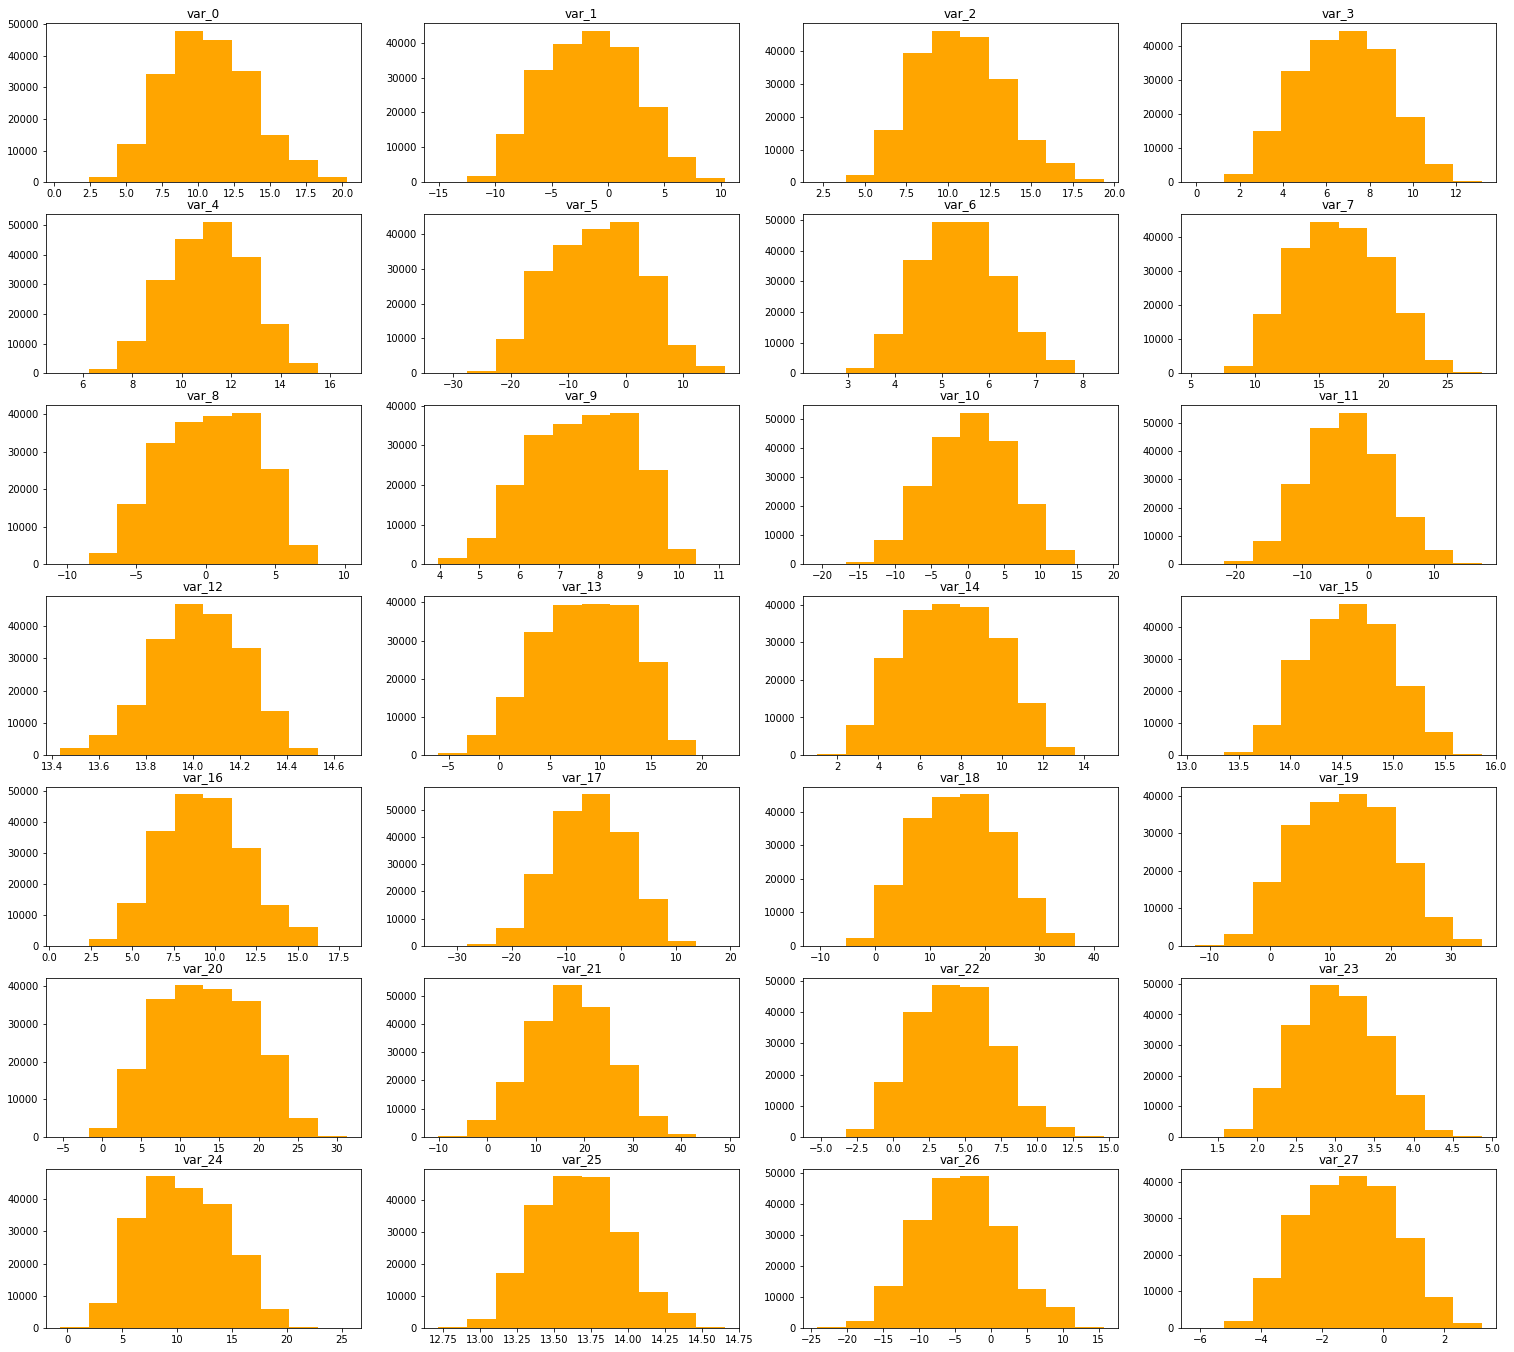

In [12]:
print('Distributions of first 28 columns of training data')

plt.figure(figsize=(26, 24))
for i, col in enumerate(list(df_train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(df_train[col], color = "Orange")
    plt.title(col)

Distributions of the last 28 columns of training data


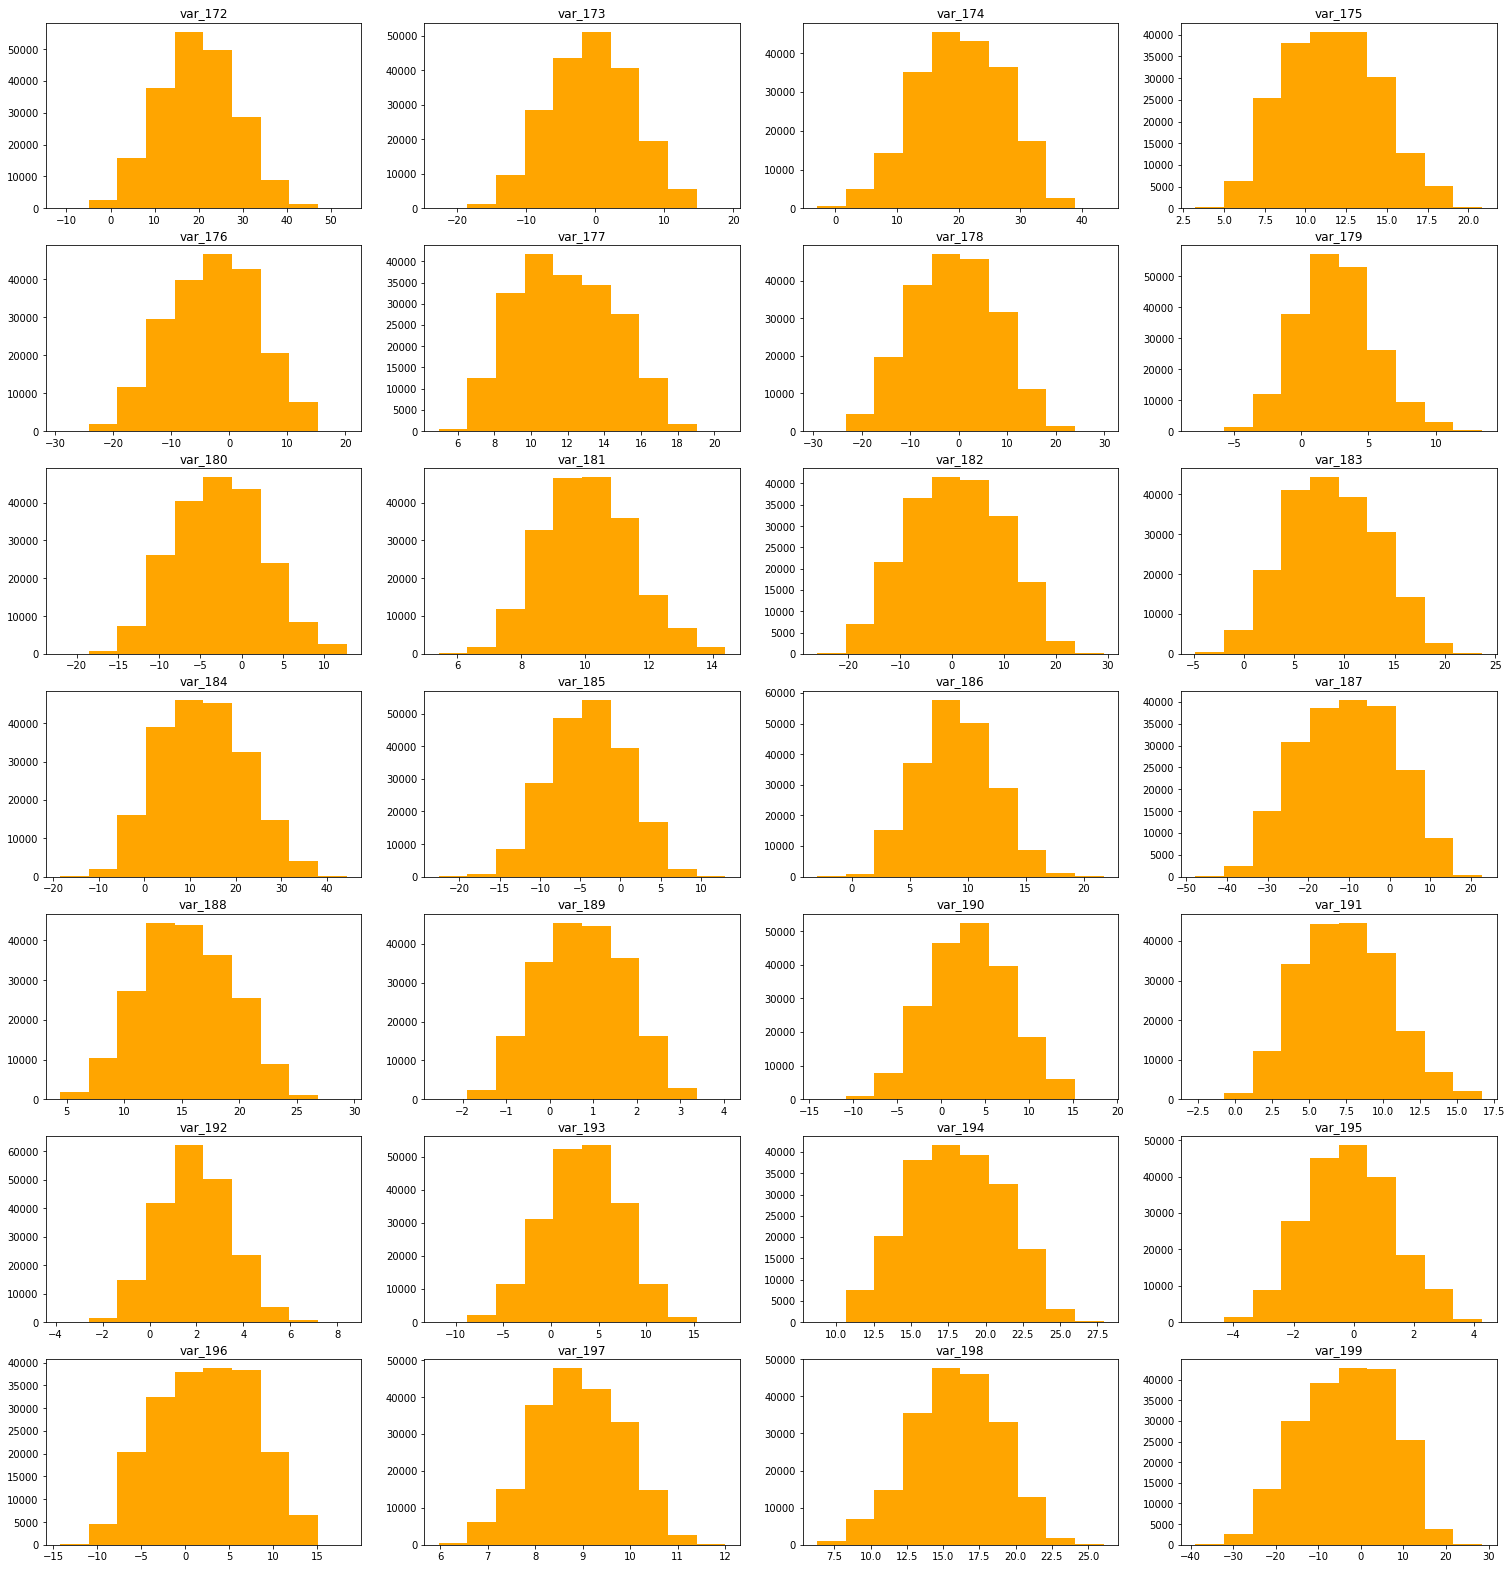

In [13]:
print('Distributions of the last 28 columns of training data')

plt.figure(figsize=(26, 28))
for i, col in enumerate(list(df_train.columns)[174:202]):
    plt.subplot(7, 4, i + 1)
    plt.hist(df_train[col],color = "Orange")
    plt.title(col)

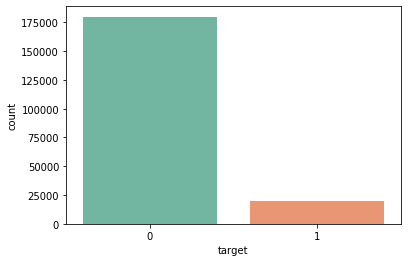

In [14]:
sns.countplot(df_train['target'], palette='Set2')

In [15]:
print (df_train['target'].value_counts())
df_train['target'].value_counts(normalize = True)

0    179902
1     20098
Name: target, dtype: int64


0    0.89951
1    0.10049
Name: target, dtype: float64

We can make few observations here:   

* Standard deviation is relatively **large** for both training and testing data
 
* Mean values for both training and testing are distributed over a **large range**. Variables are quite different from each other.

* Min, max, mean, std values for train and test data are **quite close** to each other.

* Target variable is binary and has class imbalance: **10% of samples belonging to 1 class**;


## <a id='32'>Density plots of features</a>  

Let's show now the density plot of variables in train dataset. 

## Comparision of 0 and 1 class in training data for each variable 

We will be representing with different **colors** the **distribution** for values with **target** value **0** and **1**.

In [16]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('darkgrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(22,25))
    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        #A distplot plots a univariate distribution of observations. 
        #The distplot() function combines the matplotlib hist function with the seaborn kdeplot() and rugplot() functions.
        sns.distplot(df1[feature], hist=False,label=label1,color = "red")
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=5, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=5)
    plt.show();

The first 100 variables from **var_0** till **var_99** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

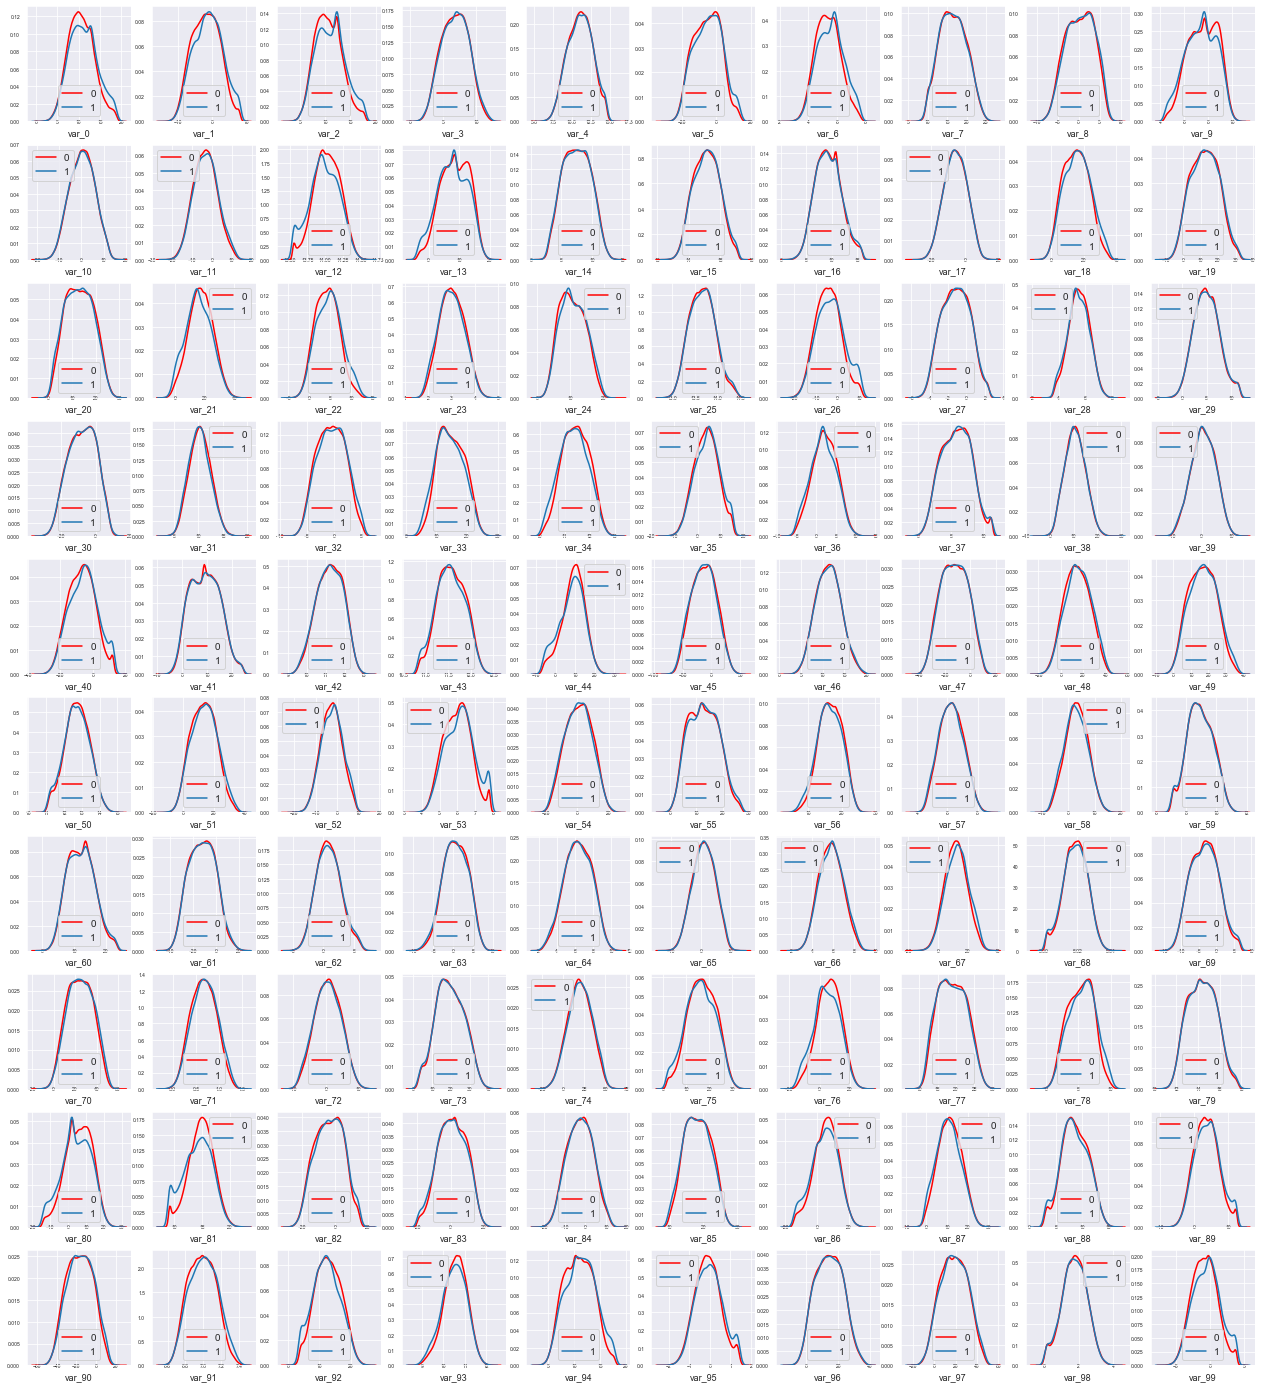

In [17]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
features = df_train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

The last 100 variables from **var_100** till **var_199** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

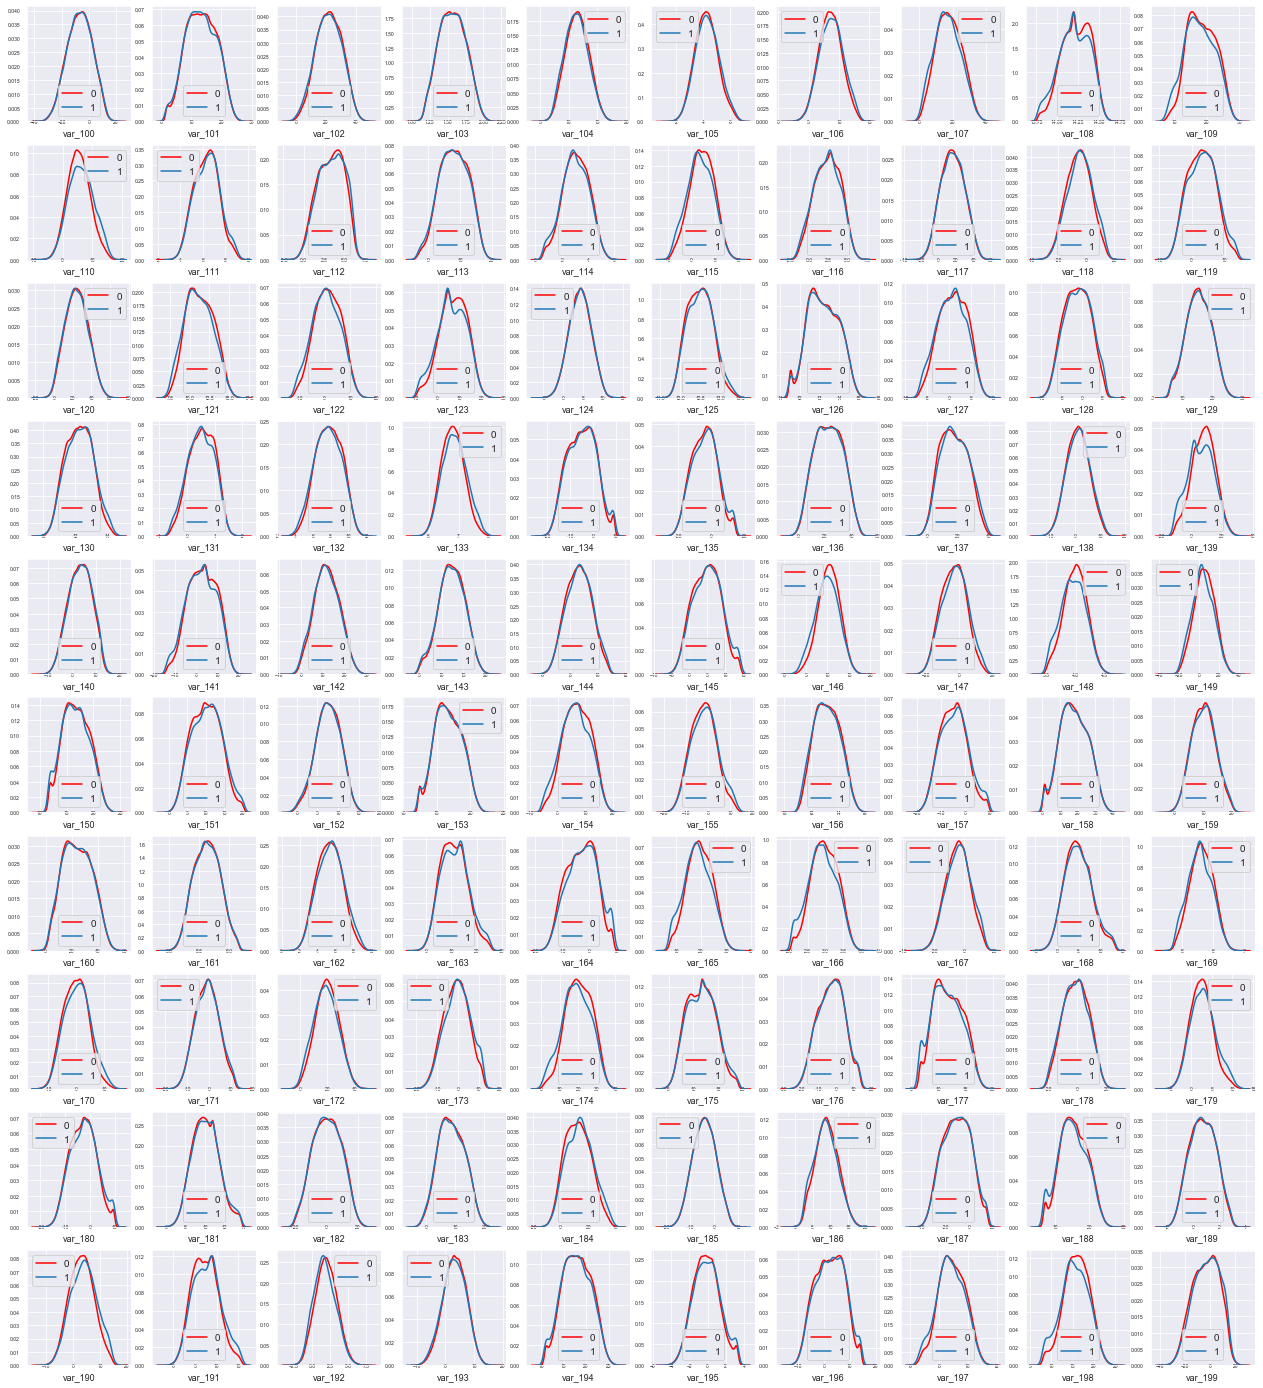

In [18]:
features = df_train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

We can observe that there is a considerable number of features with significant different distribution for the two target values.  
For example, **var_0**, **var_1**, **var_2**, **var_6**, **var_9**, **var_13**, **var_106**, **var_109**, **var_139** and many others.

Some features, such as **var_2**, **var_13**, **var_26**, **var_55**, **var_175**, **var_184**, **var_196** show a distribution that resembles to a **bivariate distribution**.

In statistics, **bivariate data is data on each of two variables, where each value of one of the variables is paired with a value of the other variable. Typically it would be of interest to investigate the possible association between the two variables**

We will take this into consideration in the future for the selection of the features for our prediction model.  

Le't s now look at the distribution of the same features in parallel in train and test datasets. 

The first 100 values are displayed in the following cell

Let's show now the density plot of variables in train and test dataset. 

## Comparision of of train and test data for each variable 

We will be representing with different **colors** the **distribution** for values with **each variable** value for **train** and **test**.

The first 100 variables from **var_0** till **var_99** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

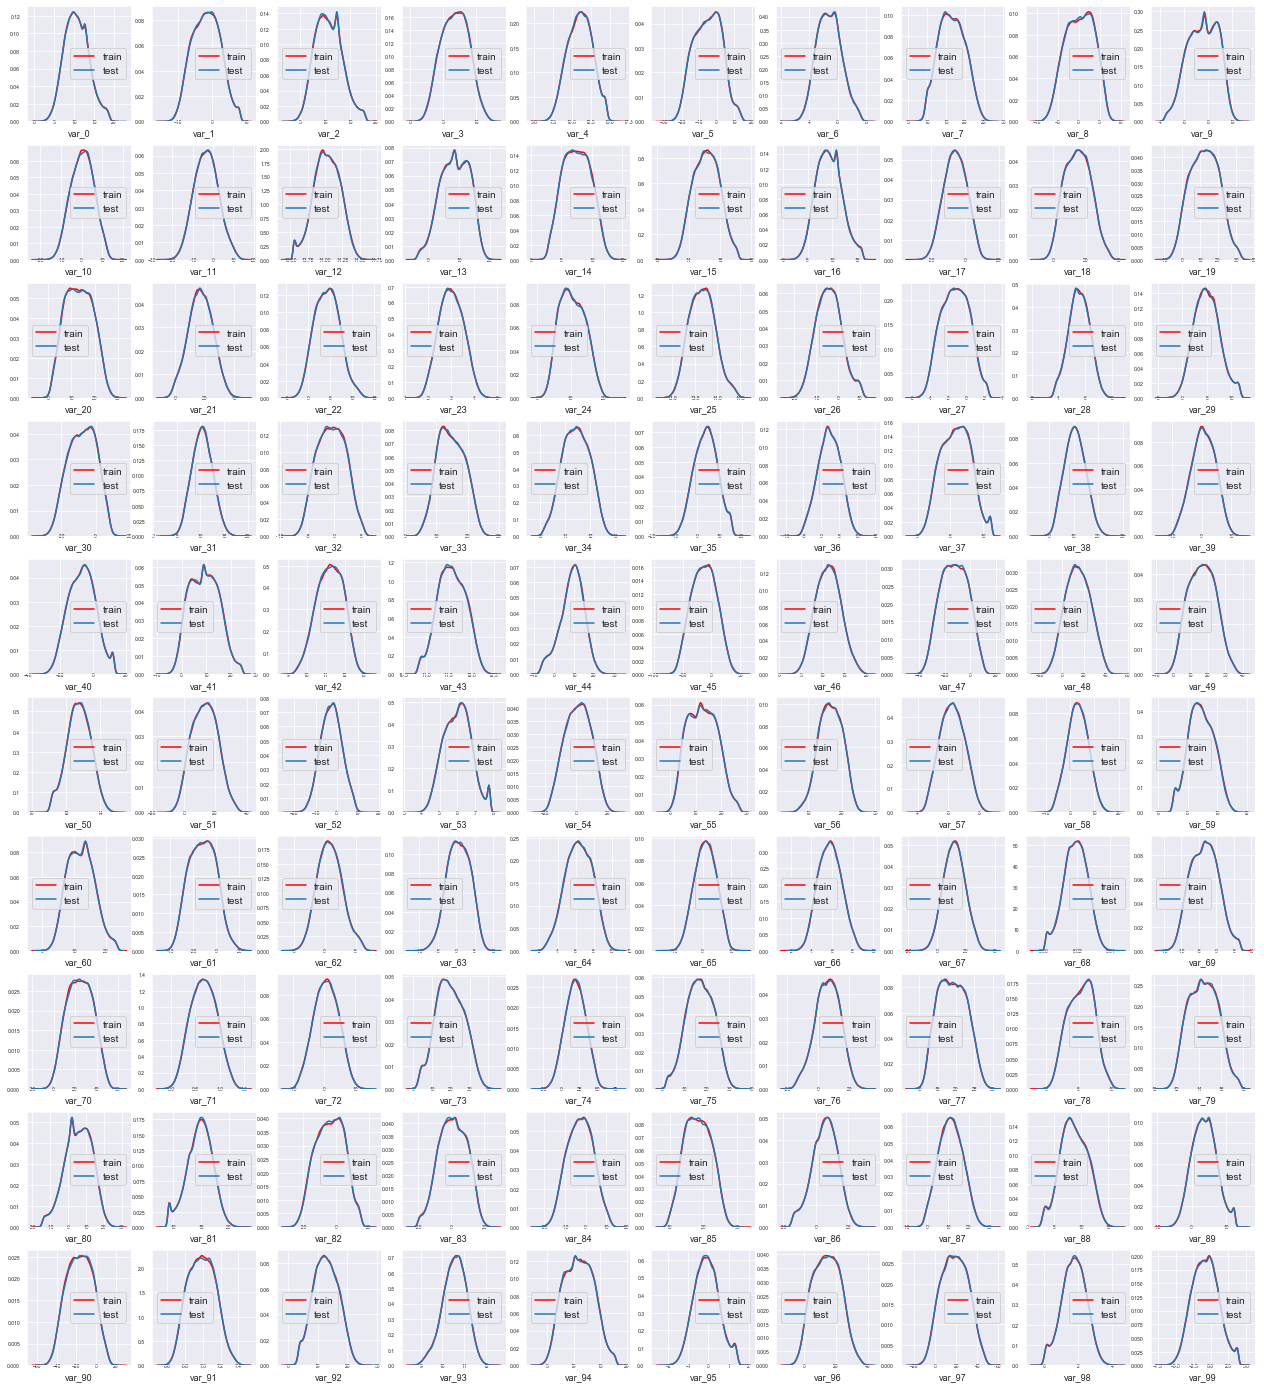

In [19]:
features = df_train.columns.values[2:102]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

The last 100 variables from **var_100** till **var_199** are depicted in the following cell:

<Figure size 432x288 with 0 Axes>

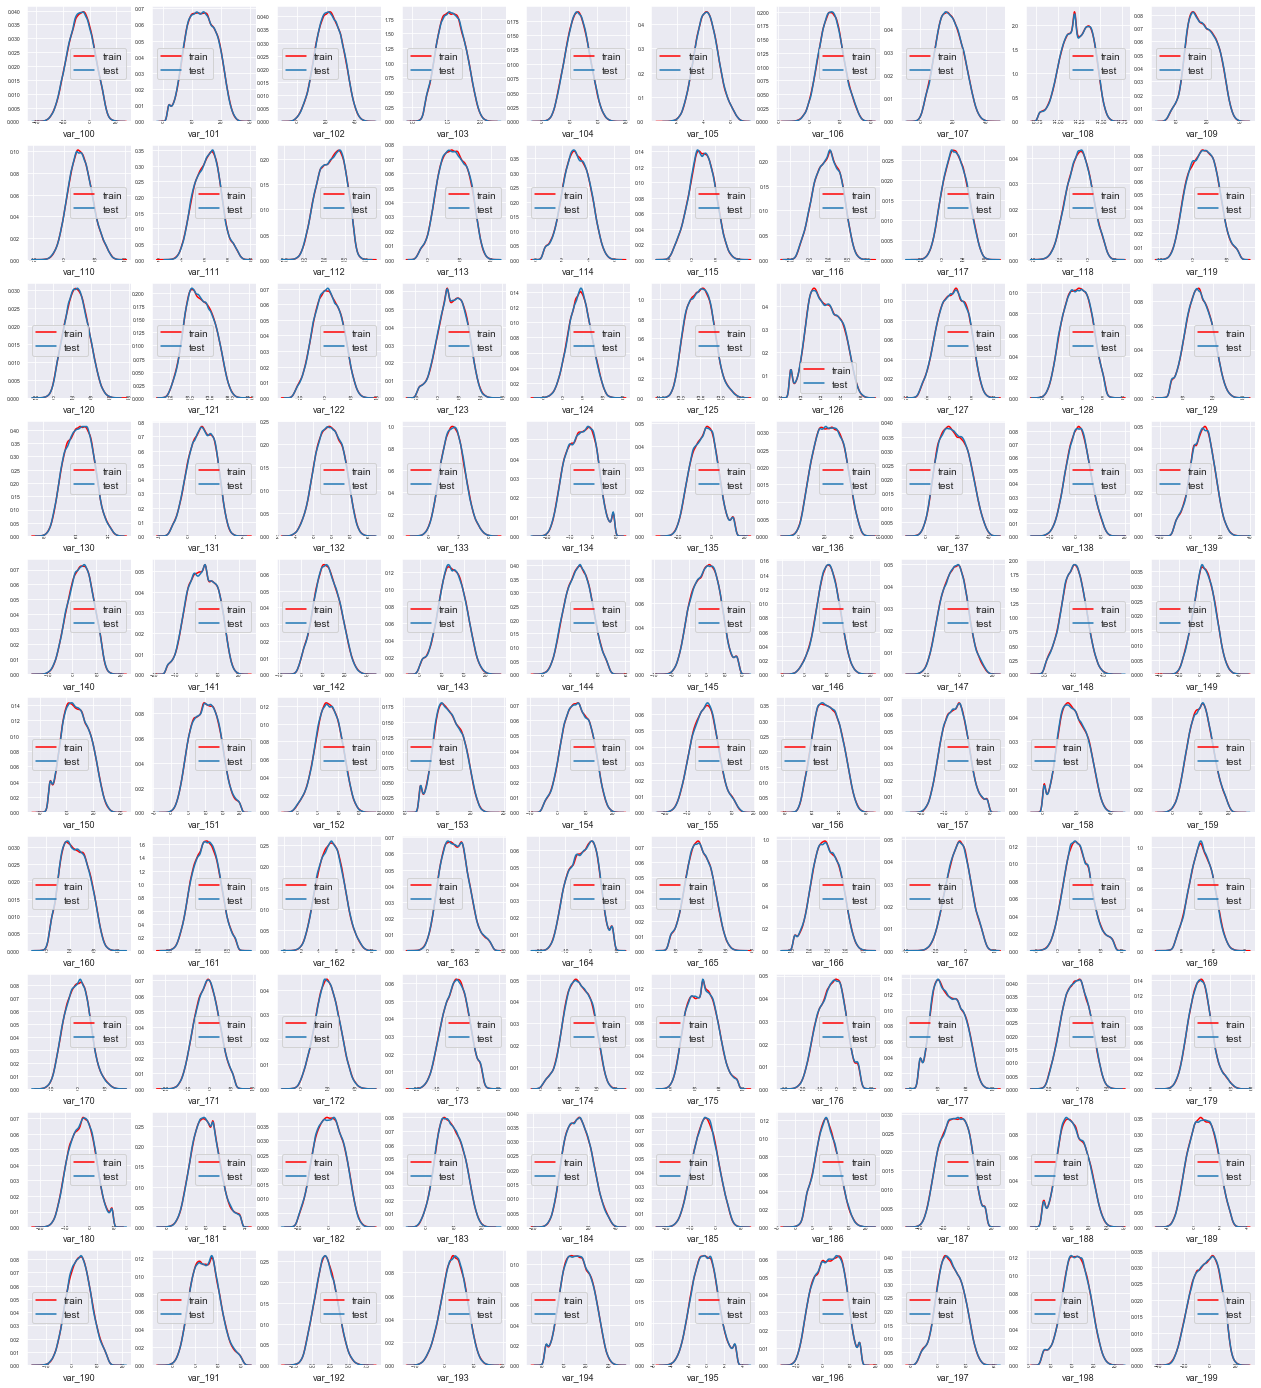

In [20]:
features = df_train.columns.values[102:202]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

The train and test seems to be well ballanced with respect with distribution of the numeric variables.  

## <a id='33'>Distribution of mean and std</a>  



Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

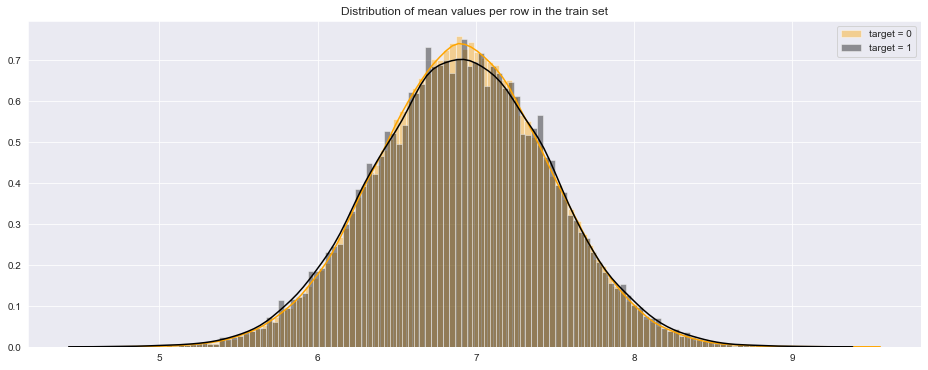

In [21]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="black", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.

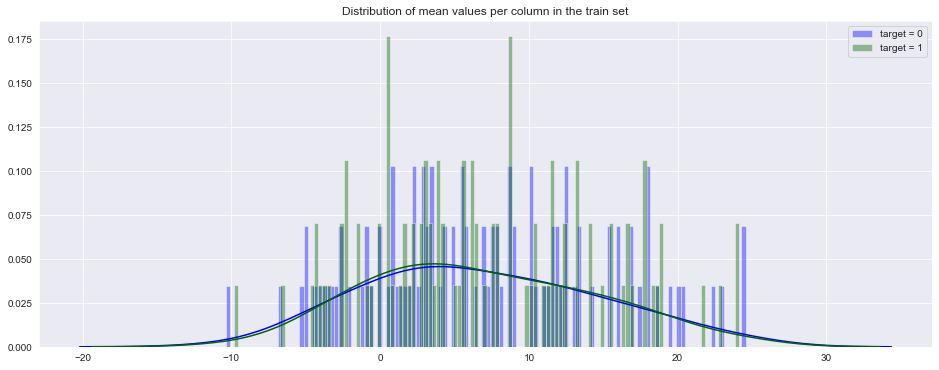

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkgreen", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## <a id='34'>Distribution of min and max</a>  

Let's check the distribution of min per row in the train and test set.

Let's show now the distributions of min values per row in train set, separated on the values of target (0 and 1).

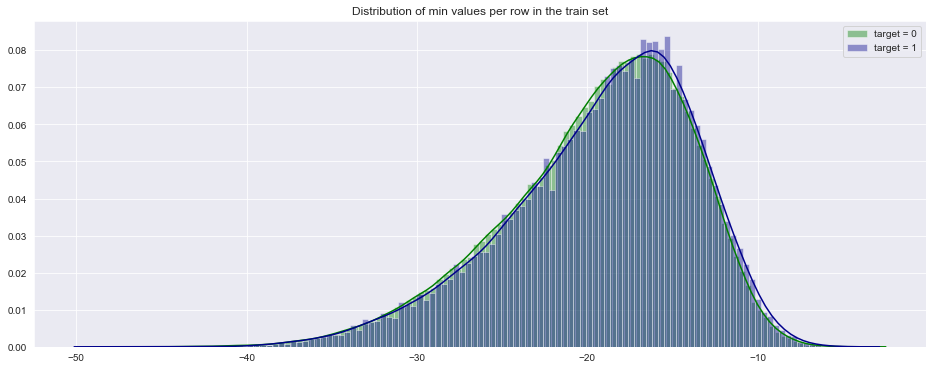

In [23]:
t0 = df_train.loc[df_train['target'] == 0]
t1 = df_train.loc[df_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

We show here the distribution of min values per columns in train set.

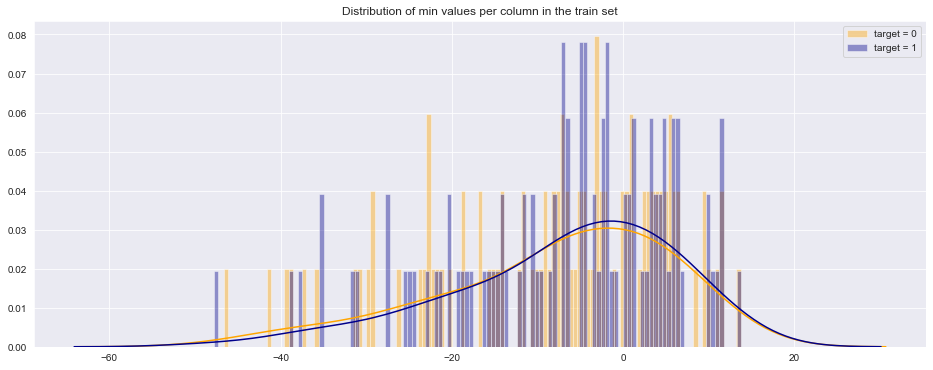

In [24]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show now the distribution of max values per rown in the train set.

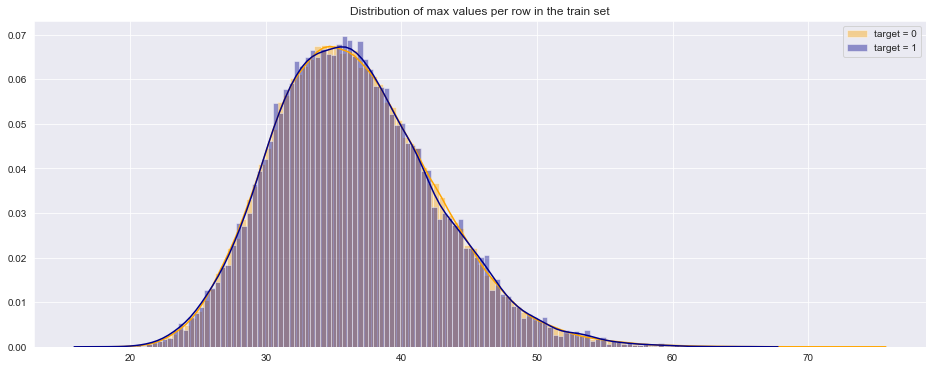

In [25]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show also the distribution of max values per columns in the train set.

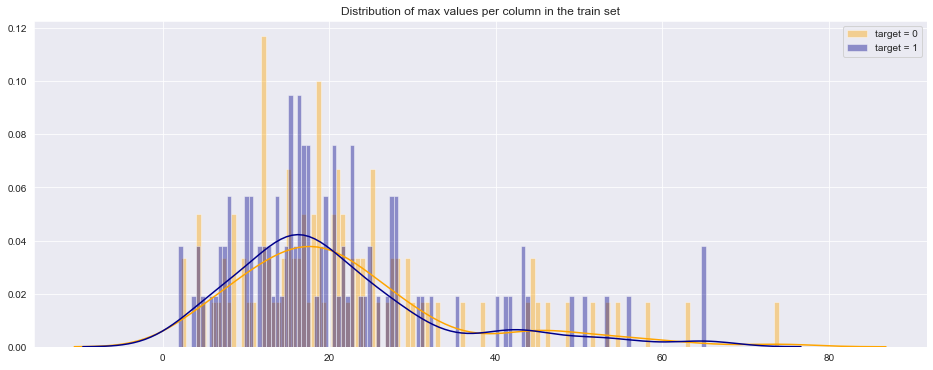

In [26]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## <a id='36'>Features correlation</a>  

We calculate now the correlations between the features in train set.  
The following table shows the first 10 the least correlated features.

In [27]:
%%time
correlations = df_train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Wall time: 4.09 s


Let's look to the top most correlated features, besides the same feature pairs.

In [28]:
correlations.tail(10)

,level_0,level_1,0
9890,var_193,var_172,0.008163
9891,var_172,var_193,0.008163
9892,var_162,var_127,0.008555
9893,var_127,var_162,0.008555
9894,var_122,var_132,0.008956
9895,var_132,var_122,0.008956
9896,var_146,var_169,0.009071
9897,var_169,var_146,0.009071
9898,var_183,var_189,0.009359
9899,var_189,var_183,0.009359


Let's see also the least correlated features.

In [29]:
correlations.head(10)

,level_0,level_1,0
0,var_109,var_126,1.313947e-07
1,var_126,var_109,1.313947e-07
2,var_177,var_100,3.116544e-07
3,var_100,var_177,3.116544e-07
4,var_150,var_116,6.628008e-07
5,var_116,var_150,6.628008e-07
6,var_173,var_176,1.318335e-06
7,var_176,var_173,1.318335e-06
8,var_109,var_157,2.494615e-06
9,var_157,var_109,2.494615e-06


The correlation between the features is very small. 

## <a id='37'>Duplicate values</a>  

Let's now check how many duplicate values exists per columns.

In [30]:
%%time
features = df_train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = df_train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = df_test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Wall time: 6.16 s


Let's show the top 15 max of duplicate values per train set.

In [31]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


Let's see also the top 15 number of duplicates values per test set.

In [32]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

# <a id='5'>Modelling</a>  

From the train columns list, we drop the ID and target to form the features list.

In [33]:
features = [c for c in df_train.columns if c not in ['ID_code', 'target']]
target = df_train['target']

# Definition/Documentation of Hyperparameters for the model [4] [6]

1. **num_leaves**: number of leaves in full tree, default: 31
2. **min_data_in_leaf**: It is the minimum number of the records a leaf may have. The default value is 20, optimum value. It is also used to deal over fitting

 This is a very important parameter to **prevent over-fitting** in a leaf-wise tree. Its optimal value depends on the number of training samples and **num_leaves**. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
 
3. binary classification
4. **max_depth**: It describes the maximum depth of tree. This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.
5. **learning_rate**: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…
6. **boosting**: defines the type of algorithm you want to run, default=gdbt
**gbdt: traditional Gradient Boosting Decision Tree** 

7. **bagging_freq** 🔗︎, default = 0, type = int, aliases: subsample_freq
* frequency for bagging
* 0 means disable bagging; k means perform bagging at every k iteration. Every k-th iteration, LightGBM will randomly select bagging_fraction * 100 % of the data to use for the next k iterations
8. **bagging_fraction**: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.
* default = 1.0, type = double, aliases: sub_row, subsample, bagging, 
* constraints: 0.0 < bagging_fraction <= 1.0
* like feature_fraction, but this will randomly select part of data without resampling
* can be used to speed up training
* can be used to deal with over-fitting
9. **boost_from_average** 🔗︎, default = true, type = bool ; used only in regression, binary, multiclassova and cross-entropy applications adjusts initial score to the mean of labels for faster convergence
10. **feature_fraction**: Used when your boosting(discussed later) is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.
11. **metric**: Area under the curve
12. **min_sum_hessian_in_leaf** 🔗︎, default = 1e-3, type = double, aliases: min_sum_hessian_per_leaf, min_sum_hessian, min_hessian, min_child_weight, constraints: min_sum_hessian_in_leaf >= 0.0
minimal sum hessian in one leaf. **Like min_data_in_leaf, it can be used to deal with over-fitting**
13. **num_threads**: for the best speed, set this to the number of real CPU cores, not the number of threads (most CPUs use hyper-threading to generate 2 threads per CPU core)

***early_stopping_round**: This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations.


In [34]:
param = {
    'num_leaves': 13, #default = 31
    'min_data_in_leaf': 80,
    'objective': 'binary', #default = regression
    'max_depth': -1,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false', 
    'feature_fraction': 0.05,
    'metric':'auc', 
    'min_sum_hessian_in_leaf': 10.0,
    'num_threads': 8,
}

# sklearn.model_selection.StratifiedKFold Documentation

**n_splitsint**, default=5
Number of folds. Must be at least 2.)

**shufflebool**, default=False
Whether to shuffle each class’s samples before splitting into batches. Note that the samples within each split will not be shuffled.

**random_stateint**, RandomState instance or None, default=None
When shuffle is True, random_state affects the ordering of the indices, which controls the randomness of each fold for each class. Otherwise, leave random_state as None. Pass an int for reproducible output across multiple function calls. 

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html:
* Predict
* save
* use best_iteration


# Running the model

If we want the splits to be reproducible, we also need to pass in an integer to random_state parameter.

In [35]:
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=44000)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=2000, early_stopping_rounds = 500)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
clf.save_model('model.txt', num_iteration=clf.best_iteration)
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[146]	training's auc: 0.87828	valid_1's auc: 0.858094
Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[142]	training's auc: 0.878272	valid_1's auc: 0.858932
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[146]	training's auc: 0.877999	valid_1's auc: 0.862392
CV score: 0.85552 


In [79]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X = df_train.drop(['ID_code', 'target'], axis=1)
y = df_train['target']
model1 = lgb.LGBMClassifier(**param,n_estimators = 200000,n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2,stratify=target)
model1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=2000, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.900829	valid_1's auc: 0.882429
[2000]	training's auc: 0.913209	valid_1's auc: 0.891422
[3000]	training's auc: 0.921353	valid_1's auc: 0.895938
[4000]	training's auc: 0.927466	valid_1's auc: 0.898076
[5000]	training's auc: 0.932614	valid_1's auc: 0.899371
[6000]	training's auc: 0.937143	valid_1's auc: 0.900171
[7000]	training's auc: 0.941342	valid_1's auc: 0.90059
[8000]	training's auc: 0.945223	valid_1's auc: 0.900852
Early stopping, best iteration is:
[7877]	training's auc: 0.944759	valid_1's auc: 0.900891


LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, boost_from_average='false',
               boosting='gbdt', feature_fraction=0.05, learning_rate=0.01,
               metric='auc', min_data_in_leaf=80, min_sum_hessian_in_leaf=10.0,
               n_estimators=200000, num_leaves=13, num_threads=8,
               objective='binary')

In [77]:
X_valid

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
67197,13.2685,-2.5178,5.7981,9.6219,8.6614,-5.7024,5.8182,21.4852,-3.2466,6.3590,...,3.2837,5.7682,1.3821,0.9178,12.3669,-0.6115,6.1036,9.3664,14.3172,8.3767
182325,7.0653,-4.7185,12.0457,6.1014,11.3524,-0.5678,4.2182,12.4889,2.2037,9.3910,...,8.8122,3.2124,1.3593,-3.6656,18.1924,2.1881,-2.6388,9.8698,18.6276,1.8328
85961,12.8913,1.6860,9.8044,6.7246,14.1186,3.2561,5.8920,16.7437,1.2124,7.5618,...,2.2152,3.5134,1.5064,-0.4749,13.4327,-2.0053,0.8006,10.3594,16.4887,-0.4164
23578,8.6630,-4.2530,11.0636,6.0641,11.2578,-16.2877,5.2588,18.5502,-4.0841,7.9608,...,-1.3347,2.5725,0.7488,-0.7791,18.0694,0.3221,-5.0997,9.3434,17.1820,10.3966
87494,10.9565,-7.3719,8.8534,8.1991,12.8435,0.0408,4.9088,19.5643,4.5504,8.5023,...,3.5864,1.2472,2.9625,6.5165,22.1163,-0.1033,10.0461,8.1229,20.0509,-7.9697
191725,9.1304,4.1263,16.6431,8.0042,11.7477,-0.1411,4.4358,17.8057,-0.1817,7.2804,...,3.1352,3.7658,-0.3158,1.9199,17.2179,-2.1200,4.3214,10.4943,11.5762,10.9290
18929,6.1846,-10.1281,11.0933,4.6641,10.3052,-10.3068,4.1098,13.7274,2.7379,7.9834,...,3.8520,5.3571,1.7729,-1.9194,16.2237,-0.4223,3.3739,8.7170,14.0730,-15.3241
171218,9.1893,-5.1090,6.9957,3.6299,10.2577,4.3824,5.8300,22.6794,-1.9656,7.6925,...,-0.3884,6.1498,2.3685,3.8151,14.1590,1.4559,6.2250,10.1010,8.5987,1.5439
164575,15.3270,-3.7375,6.3227,10.9068,8.9301,-19.8914,4.3361,12.8428,-1.6406,9.2803,...,8.1174,8.2586,1.8998,3.2441,17.7712,-0.5982,7.3303,8.3297,20.0557,0.7437
14890,15.9762,-4.1090,7.8656,4.5728,12.5237,1.3451,5.7046,18.8678,1.0562,9.1315,...,0.0937,5.2978,1.0374,0.7172,18.1553,-3.0844,-7.2122,8.9462,17.8517,4.6478


In [61]:
model1

LGBMClassifier(bagging_fraction=0.4, bagging_freq=5, boost_from_average='false',
               boosting='gbdt', feature_fraction=0.05, learning_rate=0.01,
               metric='auc', min_data_in_leaf=80, min_sum_hessian_in_leaf=10.0,
               n_estimators=20000, num_leaves=13, num_threads=8,
               objective='binary')

Let's check the feature importance.

,Feature,importance,fold
0,var_0,12,1
1,var_1,22,1
2,var_2,30,1
3,var_3,1,1
4,var_4,1,1
5,var_5,20,1
6,var_6,25,1
7,var_7,3,1
8,var_8,2,1
9,var_9,35,1


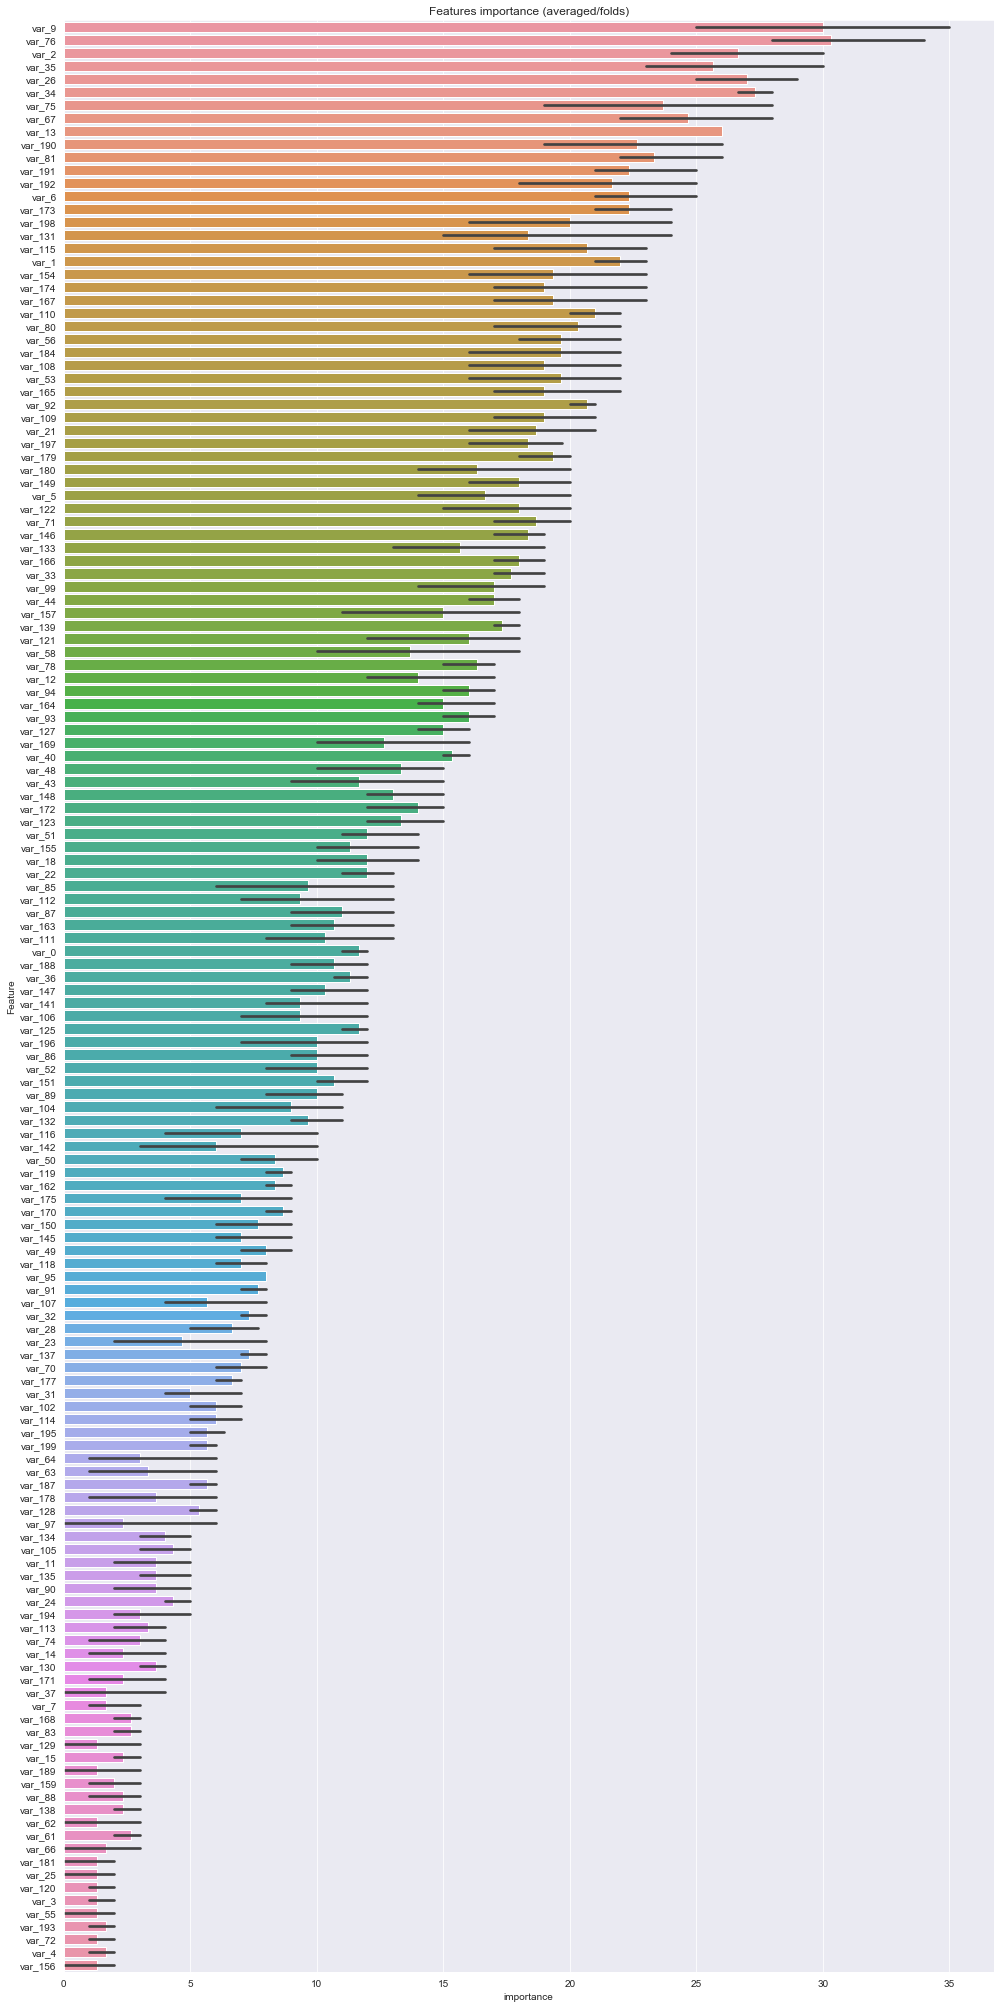

In [53]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')
feature_importance_df

In [40]:
#fold_importance_df
#feature_importance_df
clf
oof
clf
clf.save_model('mode.txt')
bst = lgb.Booster(model_file='mode.txt')
bst
#mm = lgb.
mm = lgb.Booster(model_file='model.txt')  # init model
mm

# <a id='6'>Submission</a>  

I submit the solution some days ago. The score (Area Under Receiver Operating Charachteristic Curve) received on this submission is **0.90035** which places my position in the private leaderboard as **324** ( I ranked it myself due to late submission) out of **8751 total submissions** ranking me in **TOP 4 %**. 

**Person winning** the competition received a score of **0.92573**.

![title](leaderboard.png)

In [51]:
# a = predictions
# a[a > 0.5] = 1
# a[a <= 0.5] = 0
#print(a)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_2.csv", index=False)
sub_df

,ID_code,target
0,test_0,0.0
1,test_1,0.0
2,test_2,0.0
3,test_3,0.0
4,test_4,0.0
5,test_5,0.0
6,test_6,0.0
7,test_7,0.0
8,test_8,0.0
9,test_9,0.0


# Model interpretation

**ELI5** is a python package that is used to **inspect ML classifiers** and **explain their predictions**. 
It is popularly used to debug algorithms such as **sklearn regressors** and **classifiers, XGBoost, CatBoost, Keras**, etc.  
You can read more about the package <a href="https://github.com/TeamHG-Memex/eli5">here</a>

In [64]:
features

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

In [66]:
import eli5
from eli5.sklearn import PermutationImportance
eli5.show_weights(model1, targets=[0, 1], feature_names=list(X.columns), top=50, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0202,var_81
0.0162,var_139
0.0153,var_12
0.0143,var_53
0.0133,var_110
0.0132,var_26
0.0129,var_146
0.0129,var_6
0.0124,var_166
0.0123,var_80


# <a id='7'>References</a>    

[1] https://www.kaggle.com/gpreda/elo-world-high-score-without-blending  

[2] https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-897  

[3] https://www.kaggle.com/brandenkmurray/nothing-works

[4] https://lightgbm.readthedocs.io/en/latest/Parameters.html

[5] https://towardsdatascience.com/how-to-train-test-split-kfold-vs-stratifiedkfold-281767b93869

[6] https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc